# Computing Search-Depth for Variable-Length Content

Sometimes the posterior predictive model is not the right model for a recommendation problem. This notebook covers situations where this distribution produces unexpected results. This notebook will also provide some practice in accessing components of `CompositeDistribution` and `MixtureDistribution`. 


In [56]:
from dmx.stats import * 
from dmx.utils.estimation import best_of, optimize
import numpy as np 

import matplotlib.pyplot as plt

from numpy.random import RandomState


In this example we explore computing search depth for length features. The likelihood function for a two-feature composite mixture has the following form

$$P(x_1, x_2 | \theta_1, \ldots, \theta_N) = \sum_{i = 1}^{N} P(x_1 | Z=i) P(x_2 | Z=i) P(Z=i).$$

Let's consider the case when $x_1$ is a variable length bag of words and $x_2$ is a Gaussian distribution. For simplicity, we will assume that each document contains the letters "a", "b", and "c". Each document also comes with a score that is directly related to the document. We impose this dependence via a `MixtureDistribution`. 


In [57]:
# Define a distribution for a sequence of letters from a vocabulary with a length distribution to control document size
dist11 = SequenceDistribution(CategoricalDistribution({'a':0.7, 'b':0.2, 'c':0.1}), PoissonDistribution(12.0))
# This document will come with a score / feature
dist12 = GaussianDistribution(0.0, 3.0)
# Use the CompositeDistribution to combine the two for a conditionally dependent draw. 
dist1  = CompositeDistribution((dist11, dist12))

dist21 = SequenceDistribution(CategoricalDistribution({'a':0.1, 'b':0.2, 'c':0.7}), PoissonDistribution(8.0))
dist22 = GaussianDistribution(1.0, 3.0)
dist2  = CompositeDistribution((dist21, dist22))

dist31 = SequenceDistribution(CategoricalDistribution({'a':0.1, 'b':0.7, 'c':0.2}), PoissonDistribution(4.0))
dist32 = GaussianDistribution(-1.0, 3.0)
dist3  = CompositeDistribution((dist31, dist32))

# The MixtureDistribution is used to wrap the distributions. 
dist = MixtureDistribution(components=[dist1, dist2, dist3], w=[0.3, 0.3, 0.4])


Usually we use the distributions sampler to draw from a `dmx` distribution object. For this example, we are going to manually draw from the `MixtureDistribution` to keep labels around. This will help us visualize our data later on in the notebook. 

In [58]:
# Number of samples (document, feature) pairs
N = 50

# Which topic will be drawn from? 
comp_labels = RandomState(10).choice(3, p=np.asarray([0.3, 0.3, 0.4]), replace=True, size=N)
# Count the number of samples (out of N) for each topic
comp_cnts = np.bincount(comp_labels, minlength=3)

# doc_group will store the ids for the data.
doc_group = []
data = []

# Initialize a sampler object for each mixture topic.
samplers = [comp.sampler(seed=i) for i, comp in enumerate(dist.components)]

for xi, xz in enumerate(comp_cnts):
    if xz > 0:
        doc_group.extend([xi]*xz)
        data.extend(samplers[xi].sample(xz))

# peak at some of the data     
print(repr(data[0]))
print(repr(data[-1]))

(['a', 'a', 'a', 'a', 'c', 'a', 'a', 'b', 'a'], np.float64(3.45993269138713))
(['b'], np.float64(-1.736196763701349))


So now imagine that we need to match-up the the bags of words $x_{1,1}, \ldots, x_{1,N}$ most likely paired to a given Gaussian $x_2$. One might think that the first step would be to update our posterior given $x_2$,

$$ P(Z = i | X_2 = x_2) = \frac{P(x_2 | Z = i) P(Z = i)}{\sum_{j = 1}^{k} P(x_2 | Z = j) P(Z = j)} $$

and then rank $X_1 = x_{1,1}, \ldots, x_{1,N}$ in descending probability with the updated probability density function

$$P(X_1 | X_2 = x_2) = \sum_{i = 1}^{k} P(X_1 | Z = i) P(Z = i | X_2 = x_2).$$

We will break this up into a few computations. First we are going to pop-off the `SequenceDistribution` from the first component of the `CompositeDistribution` of each component of the `MixtureDistribution`.

In [72]:
doc_mix_comps = [u.dists[0] for u in dist.components]
print(doc_mix_comps[0])

SequenceDistribution(CategoricalDistribution({'a': 0.7, 'b': 0.2, 'c': 0.1}, default_value=0.0, name=None, keys=None), len_dist=PoissonDistribution(12.0, name=None, keys=None), len_normalized=False, name=None, keys=None)


We are going to need to evaluate $$P(X_{i, 1} | Z = k)$$ 
for each observed document $X_{1,i}$. We can do this by assigning a `MixtureDistribution` with the components from above. We will also take our observed data and perform a sequence encoding to allow for a fast evaluation for the component likelihoods for each of the 3 mixture topics. 

In [75]:
# P(Document | Z)P(Z)
dist1 = MixtureDistribution(components=doc_mix_comps, w=dist.w)
# get the document data
document_data = [x[0] for x in data]
# create a sequence encoding
enc_document_data = seq_encode(data=document_data, model=dist1)[0][1]
# Evaluate P(X_{1, i} | Z = k), should be N by 3.
ll_docs = dist1.seq_component_log_density(enc_document_data)


We are going to perform a posterior re-weighting. That is, we are creating a score that corresponding to a `MixtureDistribution` with weights $P(Z = k | X_{i, 2} = x_{i, 2})$ for each score $X_{i, 2}$. To do so, we need to pop off the score components, form a `MixtureDistribution`, and obtain the posteriors for each observed score. 

In [83]:
# P(Score | Z)P(Z)
dist2 = MixtureDistribution([u.dists[1] for u in dist.components], dist.w)
# get the data for the scores.
score_data = [x[1] for x in data]
# Sequence encoding for the score data.
enc_score_data = seq_encode(data=score_data, model=dist2)[0][1]
# Evaluate the posterior for each observed data point: P(Z=k | X_{i, 2} = x_{i, 2})
post_scores = dist2.seq_posterior(enc_score_data)

Next we are going to compute the search-depth, or ranking for each document conditioned on the scores. That is $$P(X_{i, 1} | X_{j, 2})$$
for j = 1,2,...,N. If we sort these probabilities in descending order, we should suspect that the document $X_{i, 1}$ should be in the front of the queue for score $X_{i, 2}$. Let's compute the ranks using a log-sum-exp trick.

In [84]:
# Get the max of the component log-likleihoods across the components
ll_max = np.max(ll_docs, axis=1, keepdims=True)
# Subtract the log-max and exponentiate
np.exp(ll_docs-ll_max, out=ll_docs)
# Sum across each set of posterior weights
ll_mat = np.log(ll_docs @ post_scores.T) + ll_max

The rows of `ll_mat` correspond to $\log\left(P(X_{j, 1} | X_{i, 2} = x_{i, 2})\right)$. We can compute the search depth by seeing how entries $\log\left(P(X_{j, 1} | X_{i, 2} = x_{i, 2})\right)$ are greater than $\log\left(P(X_{i, 1} | X_{i, 2} = x_{i, 2})\right)$

In [85]:
# compute the search depth
sd_score = np.sum(ll_mat >= np.diag(ll_mat)[:, None], axis=1)

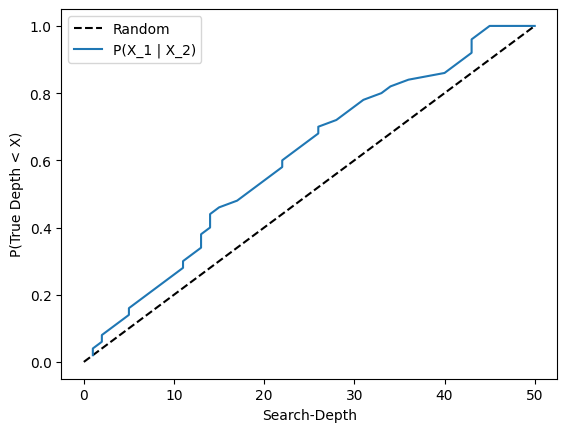

In [86]:
fig, ax = plt.subplots()

ax.plot([0,N], [0,1], '--k', label='Random')
ax.plot(np.sort(sd_score).tolist() + [N], [1.0*i / N for i in range(1, N+1)] +[1], label='P(X_1 | X_2)')

ax.set_xlabel('Search-Depth')
ax.set_ylabel('P(True Depth < X)')
ax.legend();

That looks pretty bad. Can you think of why this may be the case? To help you think about what may be going on, let's visualize the data a little bit using the posteriors for the entire data set. That is, let's use the scores and the documents paired up to plot $P(Z=k | X_{i,1}, X_{2,i})$.

In [87]:
# what if instead we plotted the documents? 

import numpy as np
import pandas as pd
import umap
import plotly.express as px

# ------------------------
# 1. Example Data
# ------------------------
X = dist.seq_posterior(seq_encode(data, model=dist)[0][1])
values = np.asarray([x[1] for x in data])  
labels = np.asarray(doc_group)           # for coloring
info = [str(x[0]) for x in data]

# ------------------------
# 2. Run UMAP
# ------------------------
reducer = umap.UMAP(random_state=42, n_neighbors=15, metric="hellinger")
embedding = reducer.fit_transform(X)

# ------------------------
# 3. Build DataFrame for Plotly
# ------------------------
df = pd.DataFrame({
    'UMAP1': embedding[:, 0],
    'UMAP2': embedding[:, 1],
    'Label': labels,
    'Value': values,
    'Document': info,
})

# ------------------------
# 4. Plot with hover + color
# ------------------------
fig = px.scatter(
    df,
    x='UMAP1',
    y='UMAP2',
    color='Label',                # color scale based on Value
    hover_data={
        'Value': ':.2f',
        'Document': True,
        'Label': True
    },
    title='UMAP Projection: P(Z=z | Score, Document)'
)

fig.update_traces(marker=dict(size=8, opacity=1.0))
fig.update_layout(coloraxis_colorbar_title='Value')

fig.show()



/Users/walder2/python_envs/dmx_kernel/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



The data above is colored by their known mixture topics (in general you would not know this information). We can see there are three distinct groups that almost all seem homogeneous. Now let's see what happens when we only look at the information from the scores $P(Z = k | X_{i, 2})$.

In [89]:
# what if instead we plotted the documents? 

import numpy as np
import pandas as pd
import umap
import plotly.express as px

# ------------------------
# 1. Example Data
# ------------------------
X = post_scores
values = np.asarray([x[1] for x in data])  
labels = np.asarray(doc_group)           # for coloring
info = [str(x[0]) for x in data]

# ------------------------
# 2. Run UMAP
# ------------------------
reducer = umap.UMAP(random_state=42, n_neighbors=15, metric="hellinger")
embedding = reducer.fit_transform(X)

# ------------------------
# 3. Build DataFrame for Plotly
# ------------------------
df = pd.DataFrame({
    'UMAP1': embedding[:, 0],
    'UMAP2': embedding[:, 1],
    'Label': labels,
    'Value': values,
    'Document': info,
})

# ------------------------
# 4. Plot with hover + color
# ------------------------
fig = px.scatter(
    df,
    x='UMAP1',
    y='UMAP2',
    color='Label',                # color scale based on Value
    hover_data={
        'Value': ':.2f',
        'Document': True,
        'Label': True
    },
    title='UMAP Projection: P(Z=z | Score, Document)'
)

fig.update_traces(marker=dict(size=8, opacity=1.0))
fig.update_layout(coloraxis_colorbar_title='Value')

fig.show()



/Users/walder2/python_envs/dmx_kernel/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



The posteriors do not seem to suggest any natural clustering....let's try this again, but this time, we are going to consider the scores conditioned on the documents. That is $$P(X_{i, 2} | X_{i, 1} = x_{i, 1}).$$

We can follow a similar formula as before. This time we just need to flip which data is playing the role of the document and score.

In [100]:
# P(Document | Z)P(Z)
ll_scores = dist2.seq_component_log_density(enc_score_data)

# P(Z=z | X2= x2)
post_doc = dist1.seq_posterior(enc_document_data)

# compute P(doc | X2 = x) for each obs
ll_max = np.max(ll_scores, axis=1, keepdims=True)
np.exp(ll_docs-ll_max, out=ll_scores)
ll_mat = np.log(ll_scores @ post_doc.T) + ll_max

# compute the search depth
sd_docs = np.sum(ll_mat >= np.diag(ll_mat)[None, :], axis=0)



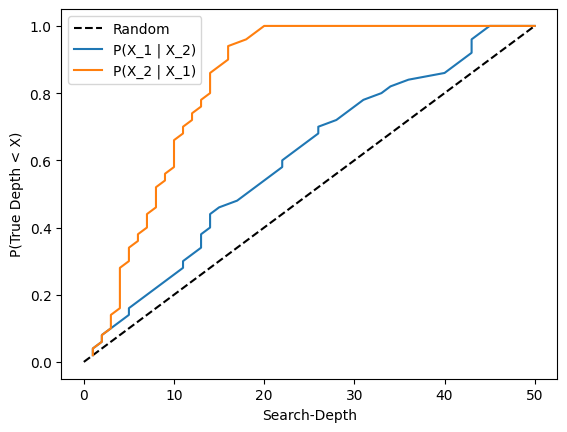

In [101]:
fig, ax = plt.subplots()

ax.plot([0,N], [0,1], '--k', label='Random')
ax.plot(np.sort(sd_score).tolist() + [N], [1.0*i / N for i in range(1, N+1)] +[1], label='P(X_1 | X_2)')
ax.plot(np.sort(sd_docs).tolist() + [N], [1.0*i / N for i in range(1, N+1)] +[1], label='P(X_2 | X_1)')

ax.set_xlabel('Search-Depth')
ax.set_ylabel('P(True Depth < X)')
ax.legend();

The results look much better. It is worth thinking about why this worked out and what you need to be cautious of when re-weighting mixture models. In this example, we saw that although the mixture models were attempting to accomplish the same task, the conditioning feature made a significant differenece in our ability to recover pairings. 